In [6]:
import sys
sys.path.append('..')
from helpers import util
import cv2
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
import scipy.spatial


In [24]:
# format 4x3 [origin,xaxis,yaxis,zaxis]
def plot_as_axes(ax,three_pts):
    ax.plot(three_pts[[0,1],0],three_pts[[0,1],1],three_pts[[0,1],2],label = 'x')
    ax.plot(three_pts[[0,2],0],three_pts[[0,2],1],three_pts[[0,2],2],label = 'y')
    ax.plot(three_pts[[0,3],0],three_pts[[0,3],1],three_pts[[0,3],2],label = 'z')

def get_cam_rot_t(in_dir, cell_num, cam_range, im_num = None):
    to_ret = []
    for cam in cam_range:
        vals_file = [cell_num,cam]
        if im_num is not None:
            vals_file.append(im_num)
#         print (vals_file)
        in_file = os.path.join(in_dir, '_'.join(vals_file)+'.npz')
        if not os.path.exists(in_file):
            continue
#         print (in_file, os.path.exists(in_file))
        loaded = np.load(in_file)
        [rvec, tvec] = [loaded[key] for key in ['rvec','tvec']]
        rot, jacob = cv2.Rodrigues(rvec)
        camera_pos = np.matmul(-rot.T,tvec) 
        to_ret.append((camera_pos, rot, tvec))
    return to_ret
        


# visualizing camera positions

2 2976


<IPython.core.display.Javascript object>


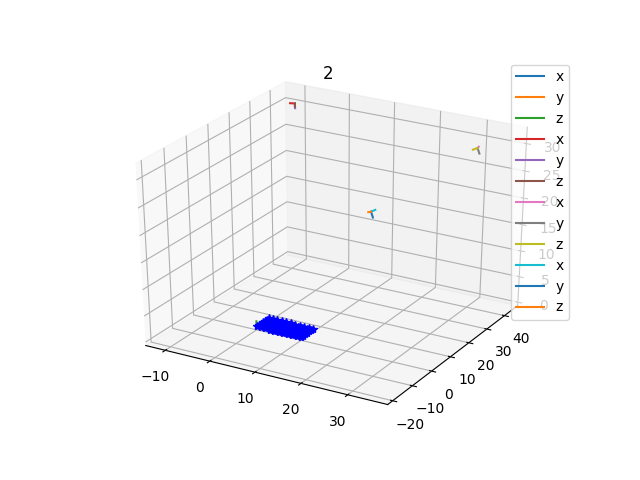

2 2947


<IPython.core.display.Javascript object>


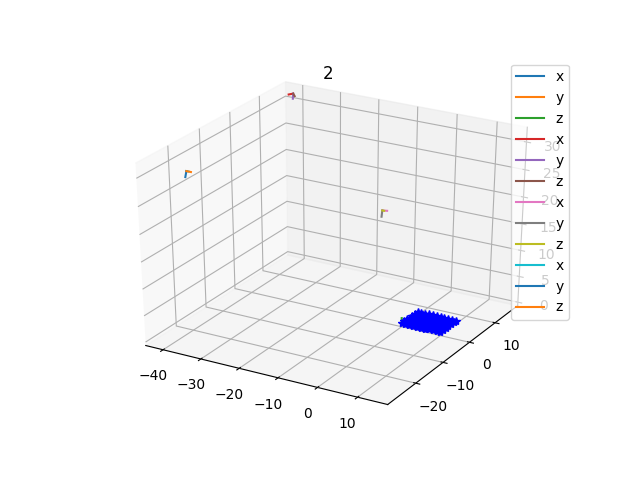

2 2662


<IPython.core.display.Javascript object>


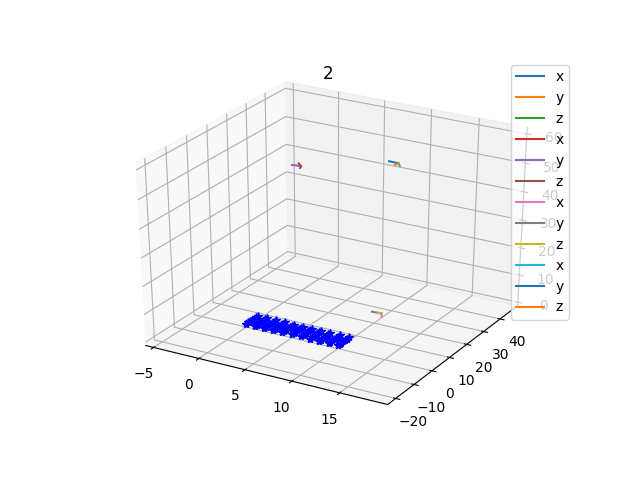

2 3047


<IPython.core.display.Javascript object>


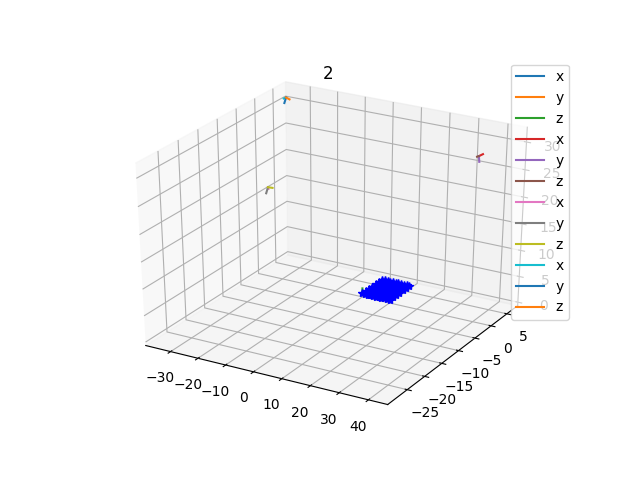

2 2953


<IPython.core.display.Javascript object>


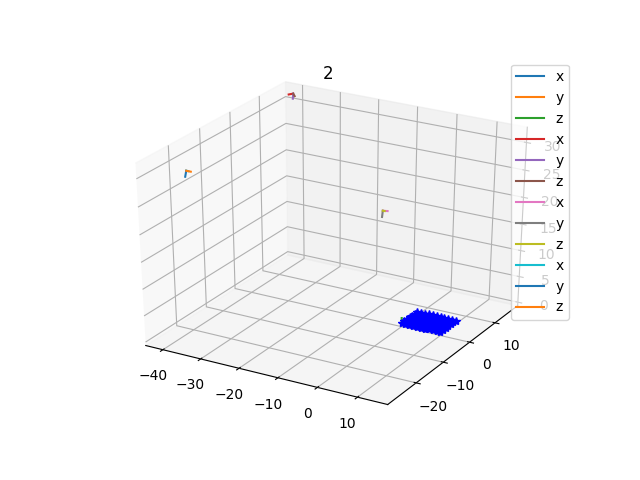

2 2605


<IPython.core.display.Javascript object>


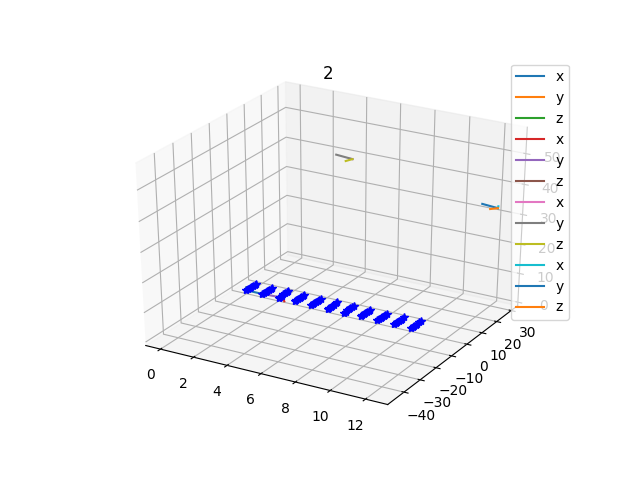

2 2674


<IPython.core.display.Javascript object>


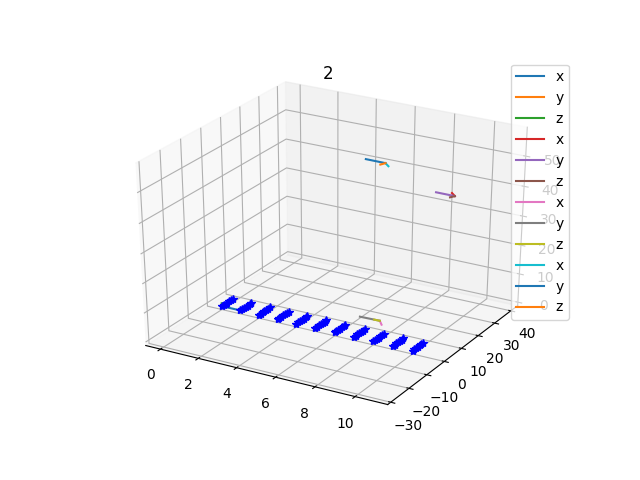

2 2655


<IPython.core.display.Javascript object>


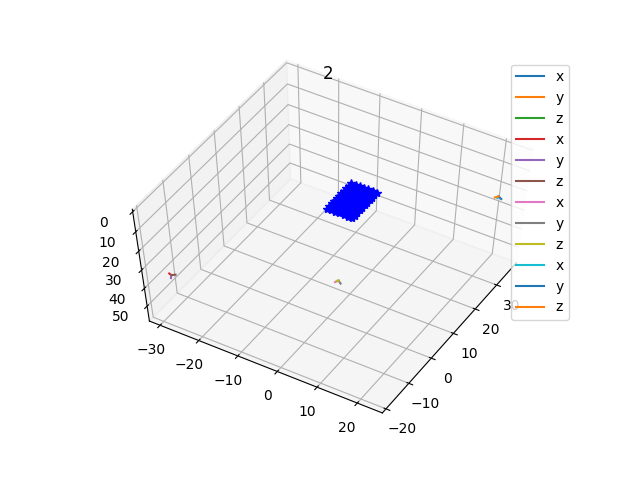

In [30]:
pts = [[0,0,0],[1,0,0],[0,1,0],[0,0,1]]
pts = np.array(pts)
# print (pts)

in_dir = '../../data/camera_calibration_frames_redo/to_copy_local_manual'
cell_num = ['1','2']
cam_range = [str(val) for val in range(4)]
im_num = None

# im_dir = 
in_dir = '../../data/camera_calibration_frames_try2/extrinsics'
cell_nums = ['2']
im_nums = [2976, 2947, 2662, 3047, 2953, 2605, 2674, 2655]
cam_range = [str(val) for val in [0,1,2,3]]
check_rows = 11
check_cols = 7


objp = []
for row in range(check_rows):
    for col in range(check_cols):
        objp.append([row,col, 0])
objp = np.array(objp,dtype= np.float)

for cell_num in cell_nums:
    for im_num in im_nums:
        print (cell_num, im_num)
        cam_rot_t = get_cam_rot_t(in_dir, cell_num, cam_range, str(im_num))

        new_axis_all = []
        for cam_pos, rot, tvec in cam_rot_t:
            pts_new = (pts.T)-tvec
    #         inv = (rot - rot.T)/2.
            camera_axis = np.matmul(rot.T,pts_new).T
            camera_axis = camera_axis
            new_axis_all.append(camera_axis)

        fig = plt.figure()

        ax = fig.gca(projection='3d')
        ax.set_title(cell_num)
    #     ax.set_aspect('equal')
        plot_as_axes(ax,pts)
        for camera_axis in new_axis_all:
            plot_as_axes(ax,camera_axis)
        plt.plot(objp[:,0],objp[:,1],objp[:,2],'*b')
        ax.legend()
        plt.show()

# verifying cam2cam world2cam

[[  0.         212.94085583 143.51148034]
 [212.94085583   0.         257.29636838]
 [143.51148034 257.29636838   0.        ]]
[[  0.         212.94085583 143.51148034]
 [212.94085583   0.         257.29636838]
 [143.51148034 257.29636838   0.        ]]
[[  0.         212.94085583 143.51148034]
 [212.94085583   0.         257.29636838]
 [143.51148034 257.29636838   0.        ]]


<IPython.core.display.Javascript object>


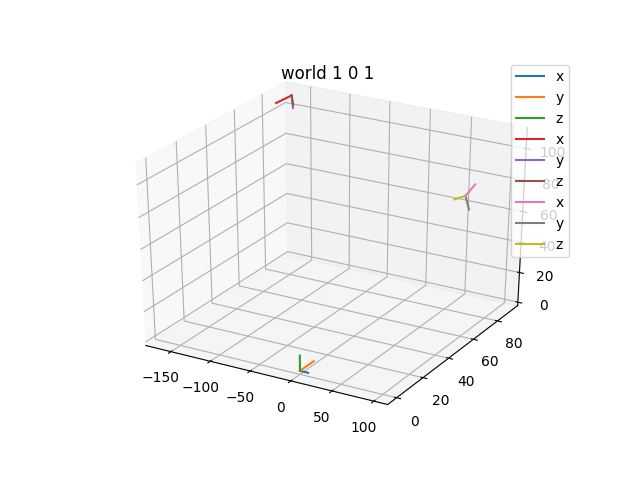

(3, 4)
(3, 4)
(3, 4)


<IPython.core.display.Javascript object>


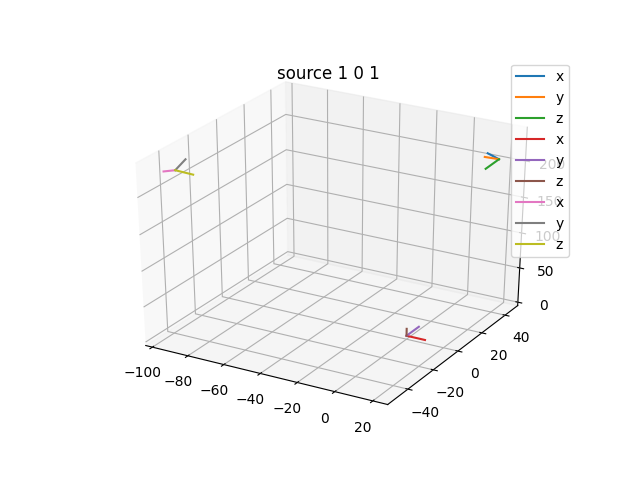

(3, 4)
(3, 4)
(3, 4)


<IPython.core.display.Javascript object>


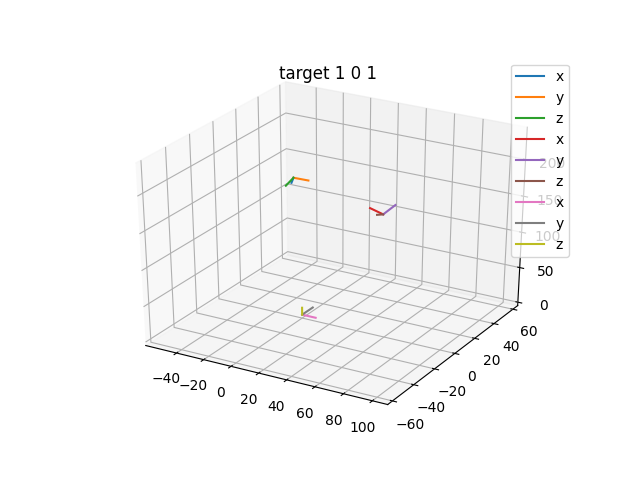

(3, 4)
(3, 4)
(3, 4)
[[  0.         212.94085583 156.32454415]
 [212.94085583   0.         291.96468948]
 [156.32454415 291.96468948   0.        ]]
[[  0.         212.94085583 156.32454415]
 [212.94085583   0.         291.96468948]
 [156.32454415 291.96468948   0.        ]]
[[  0.         212.94085583 156.32454415]
 [212.94085583   0.         291.96468948]
 [156.32454415 291.96468948   0.        ]]


<IPython.core.display.Javascript object>


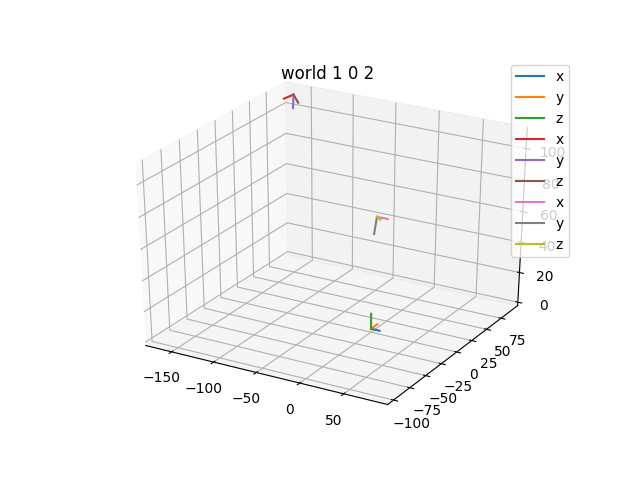

(3, 4)
(3, 4)
(3, 4)


<IPython.core.display.Javascript object>


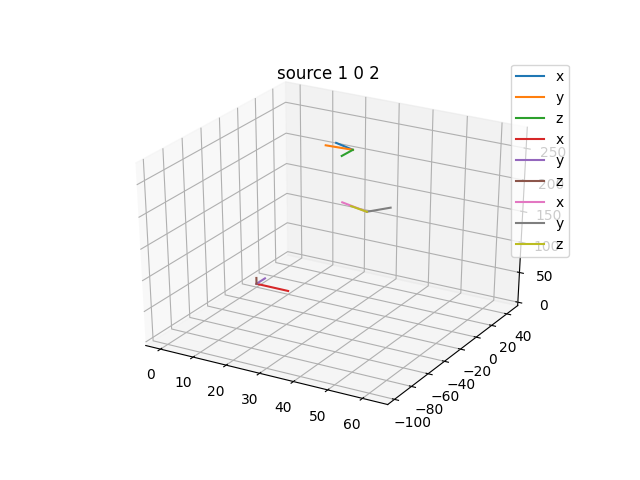

(3, 4)
(3, 4)
(3, 4)


<IPython.core.display.Javascript object>


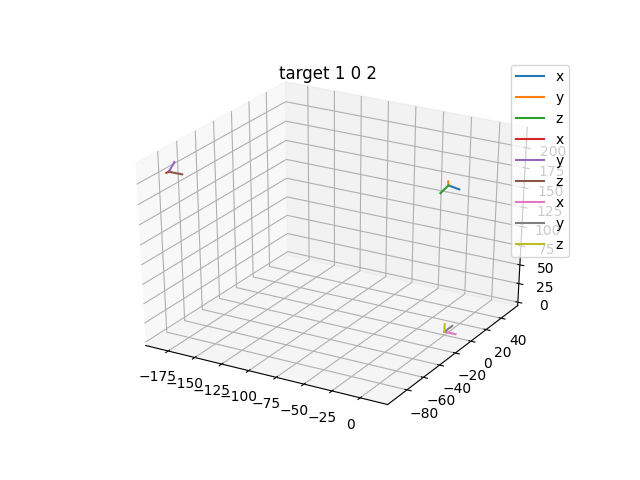

(3, 4)
(3, 4)
(3, 4)
[[  0.         212.94085583 179.45770054]
 [212.94085583   0.         151.79242565]
 [179.45770054 151.79242565   0.        ]]
[[  0.         212.94085583 179.45770054]
 [212.94085583   0.         151.79242565]
 [179.45770054 151.79242565   0.        ]]
[[  0.         212.94085583 179.45770054]
 [212.94085583   0.         151.79242565]
 [179.45770054 151.79242565   0.        ]]


<IPython.core.display.Javascript object>


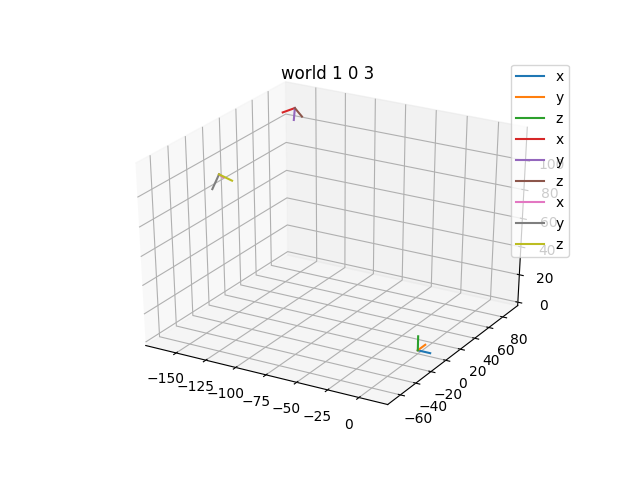

(3, 4)
(3, 4)
(3, 4)


<IPython.core.display.Javascript object>


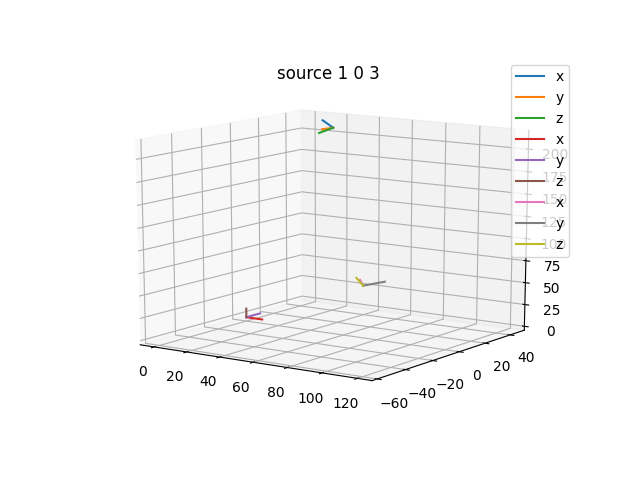

(3, 4)
(3, 4)
(3, 4)


<IPython.core.display.Javascript object>


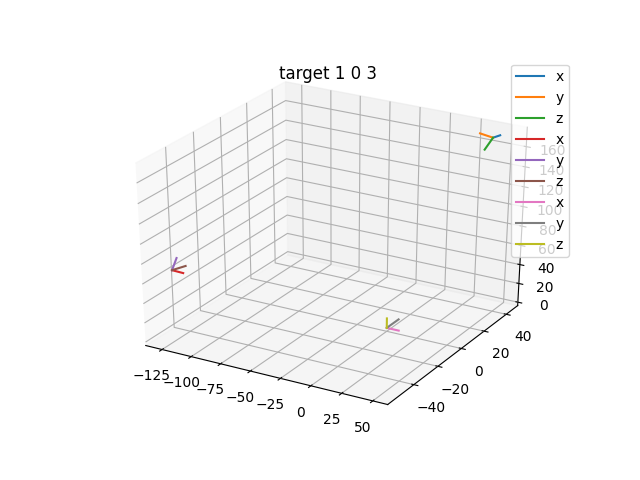

(3, 4)
(3, 4)
(3, 4)


In [16]:
pts = [[0,0,0],[1,0,0],[0,1,0],[0,0,1]]
pts = np.array(pts)
pts = pts.T*10
# print (pts)

in_dir = '../../data/camera_calibration_frames_redo/to_copy_local_manual'
cell_num = '1'
cam_range = [str(val) for val in range(4)]
for cell_num in ['1','2']:
    cam_rot_t = get_cam_rot_t(in_dir, cell_num, cam_range)
    
    rot_all = []
    tvecs = []
    for cam_pos, rot, tvec in cam_rot_t:
        
        rot_all.append(rot)
        tvecs.append(tvec)
    s_cam = 0
    w2cam_s = rot_all[s_cam]
    cam2w_s = w2cam_s.T
    s_w = np.matmul(cam2w_s,(pts-tvecs[s_cam]))
    pts_org = [pts, s_w]
    for t_cam in range(1,4):
        w2cam_t = rot_all[t_cam]
        cam2w_t = w2cam_t.T
        cam2cam = np.matmul(w2cam_t, cam2w_s)
        t_w = np.matmul(cam2w_t,(pts-tvecs[t_cam]))
        
        pts_all = pts_org+[t_w]
        in_cam_s= []
        for pts_curr in pts_all:
            p_p = np.matmul(w2cam_s,pts_curr)+tvecs[s_cam]
            in_cam_s.append(p_p)
        
        in_cam_t = []
        for pts_curr in in_cam_s:
            p_p = np.matmul(cam2cam,pts_curr-tvecs[s_cam])+tvecs[t_cam]
            in_cam_t.append(p_p)
        
#         check relative differences are the same
        pts_to_plot = [pts_all, in_cam_s, in_cam_t]
        for pts_bunch in pts_to_plot:
            origins = [pts_curr[:,0] for pts_curr in pts_bunch]
            origins = np.array(origins)
            dists = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(origins))
            print (dists)
        
        title_str = ['world','source','target']
        for idx,pts_to_plot in enumerate(pts_to_plot):
            fig = plt.figure()
            ax = fig.gca(projection='3d')
            ax.set_title(' '.join([title_str[idx],cell_num,str(s_cam),str(t_cam)]))
            for pts_curr in pts_to_plot:
                print (pts_curr.shape)
                plot_as_axes(ax,pts_curr.T)
            ax.legend()
            plt.show()
#         break
#     break

# saving rot mats

In [5]:
out_dir = '../../data/rotation_identity/'
cam_nums = range(1,9)
rot_strs = ['extrinsic_rot','extrinsic_rot_inv']
eye_mat = np.eye(3)
print (eye_mat)
out_files = [os.path.join(out_dir,rot_str+'_'+str(cam_num)+'.npy') for cam_num in cam_nums for rot_str in rot_strs]
# print (out_files)
for out_file in out_files:
    np.save(out_file, eye_mat)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [37]:
import pandas as pd
in_dir = '../../data/camera_calibration_frames_redo/to_copy_local_manual'
out_dir = '../../data/rotation_cal_1'
view_df = pd.read_csv('../../metadata/viewpoints.csv')
print (viewpoints)
cell_num = '1'
cam_range = [str(val) for val in range(4)]
for cell_num in ['1','2']:
    cam_rot_t = get_cam_rot_t(in_dir, cell_num, cam_range)
    for idx_cam,cam in enumerate(cam_range):
        cam_real = view_df.loc[view_df['subject'] == 'cell'+str(cell_num)][str(cam)].values[0]
        rot_curr = cam_rot_t[idx_cam][1]
        out_file = os.path.join(out_dir,'extrinsic_rot_'+str(cam_real)+'.npy')
#         np.save(out_file, rot_curr)
        check = np.load(out_file)
        assert np.all(rot_curr == check)

        rot_inv = rot_curr.T
        out_file = os.path.join(out_dir,'extrinsic_rot_inv_'+str(cam_real)+'.npy')
#         np.save(out_file, rot_inv)
        check = np.load(out_file)
        assert np.all(rot_inv == check)
        
        

             subject  0  1  2  3
0              aslan  2  8  4  7
1               boco  2  8  4  7
2              brava  2  8  4  7
3            herrera  1  3  5  6
4            inkasso  2  8  4  7
5              julia  1  3  5  6
6         kastanjett  2  8  4  7
7   naughty_but_nice  1  3  5  6
8         sir_holger  1  3  5  6
9              cell1  2  8  4  7
10             cell2  1  3  5  6
